# Local analysis of discussions related to PA

In [7]:
import numpy as np
import pandas as pd
import time
import nltk
import gensim
import scipy.special
path = "/Users/clem/Documents/Memoire"

### 1. Matching sentences to geographical area

For that, we need a geolocated dataset. Our first objective is therefore to match discussions to a geographical area. We start from the total dataset.

Cleaning of FB profiles :

In [ ]:
# Opening list of profiles scrapped from FB, with informations on their gender, location, etc.
#dfs = [] 

#for i in range(1,6):
#    with open( path + f'/Data/Facebook/raw/France 0{i}.txt', 'r') as f:
#        lines = [line.strip().split(',') for line in f.readlines()]
    
    # create a pandas dataframe from the list of lines
#    df = pd.DataFrame(lines)
#    dfs.append(df)
#profiles = pd.concat(dfs, ignore_index=True)
#profiles.to_csv(path + "/Data/Facebook/raw/France_total.csv")

In [8]:
# Each sentences/posts are linked to a page, and some to a user.
fb_sentences = pd.read_csv(path + '/Data/Facebook/fb_all_sentences.tsv', sep='\t')

#Each user is linked to a page

# How much are linked to a user, and potentially linkable to its profile location ?
prop_linkable = (len(fb_sentences)-fb_sentences['user_id'].isna().sum())*100/len(fb_sentences)
print(prop_linkable)
# 24,7% have a user

#fb_users = pd.read_csv(path + '/Data/Facebook/gilets_jaunes_facebook_users.csv')
#fb_users = fb_users.rename(columns={fb_users.columns[1]: 'user_id'})
#fb_users= fb_users.dropna()
#fb_users['user_id'] = fb_users['user_id'].astype(int)

# Are filtered fb sentences linked to scrapped FB users ?
#linkage1 = fb_sentences.merge(fb_users, how='inner', on='user_id')
#print((len(linkage1))*100/(len(fb_sentences)))
# 3% FB sentences are linked to scrapped FB users for gilets_jaunes_facebook_users

/var/folders/c1/c29fpvws6xn3j81txnc2_k100000gq/T/ipykernel_19192/1214937930.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  fb_sentences = pd.read_csv(path + '/Data/Facebook/fb_all_sentences.tsv', sep='\t')


24.687398070288108


In [9]:
profiles = pd.read_csv(path + '/Data/Sources/Facebook raw/France_total.csv')
profiles_area = profiles.iloc[:,[1,2,6,7]]
columns_names = ["id", "user_id", "lives_in", "comes_from"]
profiles_area.columns = columns_names
profiles_area.head()

# Two columns refereing to geographical area : how much missing values compared to the number of profiles ?
print((len(profiles_area) - profiles_area['lives_in'].isna().sum()) / len(profiles_area))
print((len(profiles_area)- profiles_area['comes_from'].isna().sum()) / len(profiles_area))
print(len(profiles_area))
# 41% of users are matched to a location

/var/folders/c1/c29fpvws6xn3j81txnc2_k100000gq/T/ipykernel_19192/850801607.py:1: DtypeWarning: Columns (1,2,11,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  profiles = pd.read_csv(path + '/Data/Sources/Facebook raw/France_total.csv')


0.45650321517043124
0.4105061228878127
19848559


Matching FB sentence to FB profiles information on area :

In [10]:
fb_sentences_merge = fb_sentences.dropna(subset=['user_id'])
fb_sentences_merge = fb_sentences_merge.merge(profiles_area, how='left', on='user_id')

# What share of sentences is not matched to a user location ? ALL
print(fb_sentences_merge['user_id'].isna().sum()/ len(fb_sentences_merge))
print(len(fb_sentences_merge))
# 713 747 sentences

# How many unique user_id are matched ? 120 462users.
print(fb_sentences_merge['user_id'].nunique())

# What share of sentences are not matched to a user location ? 85% is not matched. 99 311 sentences matched.
print(fb_sentences_merge['lives_in'].isna().sum()/len(fb_sentences_merge))
print(len(fb_sentences_merge) - fb_sentences_merge['lives_in'].isna().sum())

# Find the indices where column 'lives in' is NaN and column 'comes from' is not NaN
indices = fb_sentences_merge[fb_sentences_merge['lives_in'].isnull() & fb_sentences_merge['comes_from'].notnull()].index
# Replace the NaN values with the non-null values from column 'comes from'
fb_sentences_merge.loc[indices, 'lives_in'] = fb_sentences_merge.loc[indices, 'comes_from']

# 594 424 missing values
print(fb_sentences_merge['lives_in'].isna().sum())

fb_sentences_merge.to_csv(path + '/Data/Facebook/fb_sentences_loc.csv')

0.0
713747
120462
0.8528470172203876
105030
594424


Matching profile information on area to cities :

In [12]:
import re
from unidecode import unidecode

localities = pd.read_csv(path + '/Data/Sources/Communes/final_dataset.csv', sep=':')
localities = localities[['NAME_CLEANED', 'CODE_COM_INSEE', 'DEP']]
localities.rename(columns={'NAME_CLEANED': 'city', 'CODE_COM_INSEE' : 'CODGEO'}, inplace=True)

print(len(localities))
localities = localities.sort_values('city')
localities = localities.drop_duplicates(subset='city', keep='first')
print(len(localities))
# From 40 641 to 35 957 rows
    
fb_sentences_loc = pd.read_csv(path + '/Data/Facebook/fb_sentences_loc.csv')

fb_sentences_loc['city'] = pd.NaT
fb_sentences_loc['city'] = fb_sentences_loc['lives_in'].str.split(':').str[0]
fb_sentences_loc = fb_sentences_loc[fb_sentences_loc['city'].notna()]
print(len(fb_sentences_loc))
# 119 323 sentences located

# Cleaning city/locality names
def clean_city(city):
    # Remove accents and convert to lowercase
    cleaned_city = unidecode(city).lower()
    # Remove non-alphanumeric characters
    cleaned_city = re.sub(r'\W+', ' ', cleaned_city)
    # Tokenize the city name by splitting on spaces
    tokens = cleaned_city.split()
    return tokens

# Apply the clean_city function to the 'city' column
fb_sentences_loc['city'] = fb_sentences_loc['city'].apply(clean_city)
fb_sentences_loc['city'] = fb_sentences_loc['city'].apply(lambda x: ' '.join(x))

merged_fb_sentences_loc = fb_sentences_loc.merge(localities, on='city', how='left')
print(len(merged_fb_sentences_loc))
print(merged_fb_sentences_loc['DEP'].isna().sum())

merged_fb_sentences_loc = merged_fb_sentences_loc[merged_fb_sentences_loc['DEP'].notna()]

print(merged_fb_sentences_loc['user_id'].nunique())
# 22 601 user_id different

print(merged_fb_sentences_loc['message_id'].nunique())
# 60 640 message_id different

merged_fb_sentences_loc.to_csv(path + '/Data/Facebook/fb_sentences_loc.csv')

40641
35957
103598
103598


KeyError: 'DEP'

### 2. Geolocated PA dataset

Now we want to target discussions related to the prime d'activité. We use the same key word list as before, as our filtered geolocated dataset is supposed to be representative of the previous whole dataset.

In [ ]:
from tqdm import tqdm
import pickle as pk
import numpy as np
from sklearn import preprocessing
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
fb_sentences_loc = pd.read_csv(path + '/Data/Facebook/fb_sentences_loc.csv')

In [ ]:
# Load Word2Vec model
fb_model = Word2Vec.load(path + '/Data/Facebook/fb_model.model')

# Load vectors
word_vectors = fb_model.wv

# Load SIF file
with open(path + '/Data/Facebook/comments_sif_dict.pickle', 'rb') as pickle_file:
  sif_vec_dict = pk.load(pickle_file)

  # Get SIF weights of each word
fb_sentences_loc['tokens'] = fb_sentences_loc['sentence_clean'].apply(lambda x: str(x).split())

word_count_dict = {}
for word, index in fb_model.wv.key_to_index.items():
    word_count_dict[word] = fb_model.wv.get_vecattr(word, "count")

print('Word frequencies computed.')

sif_dict = {}
for word, count in word_count_dict.items():
    sif_dict[word] = .001 / (.001 + count)

print('SIF dictionary built.')

# Weight of prime and activite
print(sif_dict['prime'])
print(sif_dict['activite'])

Word frequencies computed.
SIF dictionary built.
2.1331053470338423e-07
7.163318650917872e-07


In [13]:
# Compute embedding for "prime + activité"
word1 = "prime"
word2 = "activite"

embedding = (0.5 * word_vectors[word1]) + (0.5 * word_vectors[word2])

# Find most similar words
similar_words = word_vectors.similar_by_vector(embedding,topn=500)

# similar_words = word_vectors.most_similar(positive = [embedding], topn=50)

# Extract the list of closest words
closest_words = [word for word, _ in similar_words]

print(closest_words)

['prime', 'activite', 'activiter', 'beneficiaire', 'exceptionnelle', 'interessemer', 'apl', 'smicard', 'imposable', 'aah', 'cotisation', 'remuneration', 'contrepartie', 'indemnite', 'salarier', 'caf', 'salaire', 'cdd', 'allocation', 'smic', 'defiscaliser', 'rsa', 'alloc', 'employeur', 'plafond', 'annuel', 'salarie', 'conversion', 'salair', 'pension', 'mensuel', 'augmentation', '100e', 'dividende', 'cessation', 'supplementaire', 'majorer', 'chomag', 'compenser', 'prestation', 'montant', 'revenu', 'versement', 'euro', 'verser', 'embauche', '200euro', 'revaloriser', 'defiscalisation', 'trimestre', 'bonus', 'compensation', 'revalorisation', 'activit', 'foyer', 'garantie', 'exoneration', 'habitation', 'invalidite', 'complementaire', 'cmu', 'indemnisation', 'bareme', 'retraire', 'plafonner', 'assurance', 'interimaire', 'majoration', 'cice', 'percevoir', 'succession', 'csg', 'licence', 'salarial', 'vieilless', 'smig', 'attribution', 'taux', 'retraite', 'chomage', 'cheque', 'energi', 'dotation

In [14]:
closest_words=['prime', 'activite', 'activiter', 'beneficiaire', 'exceptionnelle', 'interessemer', 'apl', 'smicard', 'imposable', 'aah', 'cotisation', 'remuneration', 'contrepartie', 'indemnite', 'salarier', 'caf', 'salaire', 'cdd', 'allocation', 'smic', 'defiscaliser', 'rsa', 'alloc', 'employeur', 'plafond', 'annuel', 'salarie', 'conversion', 'salair', 'pension', 'mensuel', 'augmentation', '100e', 'dividende', 'cessation', 'supplementaire', 'majorer', 'chomag', 'compenser', 'prestation', 'montant', 'revenu', 'versement', 'euro', 'verser', 'embauche', '200euro', 'revaloriser', 'defiscalisation', 'trimestre', 'bonus', 'compensation', 'revalorisation', 'activit', 'foyer', 'garantie', 'exoneration', 'habitation', 'invalidite', 'complementaire', 'cmu', 'indemnisation', 'bareme', 'retraire', 'plafonner', 'assurance', 'interimaire', 'majoration', 'cice', 'percevoir', 'succession', 'csg', 'licence', 'salarial', 'vieilless', 'smig', 'attribution', 'taux', 'retraite', 'chomage', 'cheque', 'energi', 'dotation', 'beneficier', 'simulation', 'chequ', 'mutuelle', 'emploie', 'emploi', 'sup', 'licencier', 'investissement', 'forfaitaire', 'precaire', 'licenciement', 'ressource', '100euro', 'axa', 'journalier', 'cdi', 'embaucher', 'reversion', 'contrat', 'epargne', 'rsi', 'imposition', 'aspa', 'employe', 'cumul', 'tarif', 'indemniter', 'complement', 'remboursement', 'consequent', 'contribution', 'quota', 'placement', 'conjoint', 'recette', 'prelevement', 'aide', '187', 'benefice', 'fourniture', 'familial', 'assedic', 'entreprise', '100', 'charge', 'subvention', 'travail', 'avantage', 'centime', 'entrepreneur', '300euros', 'reevaluer', 'rente', 'abonnement', 'organisme', 'taxe', 'verse', 'cotise', 'rentabilite', 'impacter', 'revenue', 'inflation', 'tva', 'reduction', 'rmi', 'entreprendre', 'benevolat', 'impot', 'compensatoire', 'degressif', 'exonerer', 'eur', 'cpam', 'plafonnement', 'partiel', 'rendement', 'patron', 'ticpe', 'creance', 'rentree', '300', 'patronal', 'embauch', 'mdph', 'logement', 'logemer', 'insertion', 'secu', 'reverse', 'chomeur', 'calculer', 'affecter', 'quid', 'cotiser', 'automobile', 'maaf', 'renouvellement', 'locatif', 'periscolaire', 'rattrapage', 'actionnaire', '1000e', 'fonctionnaire', 'budget', 'malus', 'modeste', 'pourcentage', 'reverser', 'pme', 'touchent', 'saisonnier', 'toucher', 'interim', 'paiement', 'horaire', 'etablissement', 'minimum', 'cumuler', 'acompte', 'octroyer', 'contractuel', '150', 'illicite', 'retrait', 'aidant', 'exo', 'formation', 'obligation', 'automatique', '1200', 'emolument', 'taxes', 'financement', 'hauss', 'conge', 'mirobolant', '35h', 'frais', '300e', 'offre', 'allouer', 'delocalisation', 'touche', 'faramineux', 'additionnel', 'croissance', 'inhabituel', 'loyer', '197', 'substantiel', 'maif', 'minima', 'cts', '1700', 'retraites', 'specifique', 'reconversion', 'fonction', 'diminution', 'augmenter', 'hotelier', 'qualification', 'recompense', 'astronomique', 'rds', 'calcule', '150e', 'chaumage', 'scolaire', '189', 'centim', 'derogation', 'argent', 'justificatif', '146', 'cadeal', 'diminue', 'compense', 'tver', 'barem', 'calcul', 'veuve', 'afferent', 'restauration', 'fiscale', 'diplome', 'th', 'production', 'deficitaire', 'baisse', 'progressif', 'satisfaction', 'edf', 'accorder', '780', 'artisanat', 'collectivite', '860', 'telethon', 'debitant', 'repercuter', 'allocataire', 'reparation', 'cesu', 'supp', 'charges', 'concession', 'natalite', 'doubler', 'cac40', 'annee', 'somme', 'taxation', 'prive', 'cadre', 'immobilier', 'mobilite', 'alimentaire', 'participation', 'comptable', 'reduisez', 'chomeurs', 'achat', 'comptabilite', '1400', 'enveloppe', 'tarifaire', 'tranche', 'manne', 'triple', 'inferieur', 'valoriser', 'remunerer', 'significatif', 'mois', 'veuf', 'penalise', 'pactole', 'ecace', 'penibilite', 'residence', 'activitee', 'insuffisant', 'baiss', 'valorisation', 'tpe', 'developpement', '140', 'gel', 'cout', 'hausse', '147', 'categorie', 'aesh', 'licenci', 'ponctionner', 'precariser', 'colossal', 'critere', 'dollar', '120', '1300', 'md', 'suspension', 'dependre', 'indice', '900', 'renouvelable', '1100', 'attestation', 'suppression', 'drastiquemer', '1800', 'alimentation', 'autonomie', 'tresorerie', 'minime', 'dependance', '40h', 'territorial', 'fisc', '108', '2500', 'payer', 'location', '2000e', 'abattement', 'donnee', 'consommation', 'travailleur', 'youpiiiii', 'deduire', 'annulation', '850', 'drastique', 'anciennete', 'redistribuer', 'rentier', 'secteur', 'transaction', 'percoi', 'travailler', 'habitat', 'navigo', 'obtenir', 'esat', '233', 'maladie', 'extension', 'facture', 'economier', 'surplus', 'matmut', 'penalite', 'supression', 'radier', 'amelioration', 'degrevement', 'celibataire', 'quotient', 'professionnel', 'travaille', '131', 'cotisant', 'contrainte', 'arnaque', 'reserve', 'apprentissage', 'mutation', 'depassement', 'caissier', 'miette', 'arnaqu', 'insee', 'depense', 'subside', 'ponctuel', 'speculation', 'ancienneter', 'deductible', '2020', 'applicable', 'relatif', 'redevance', 'prejudice', 'retraitre', 'fonds', 'titulaire', '151', 'net', 'exploitant', '670', 'livret', '119', 'exorbitant', '145', 'obtenu', 'aeroportuaire', 'effectuer', '2000', 'emprunt', 'administration', 'credit', '1euros', 'carriere', 'aleatoire', 'octroi', 'cadeau', 'liquidation', 'locaux', 'necessiter', 'varier', 'hydrocarbure', 'ponction', 'benevole', 'handicape', 'pm', 'durable', 'traitement', 'impots', 'convenable', '450', 'maigre', 'caution', 'mesure', '184', 'negociation', 'psa', '10milliard', 'alleger', 'donation', '161', 'denree', 'reforme', 'clause', '126', 'promettre', 'pmi', 'statutaire', 'equivaloir', '185', '600', 'considerablement', '1300e', '118', 'avancement', 'moyenne', 'fonctionnair', 'effectif', 'decent', 'gagnent', 'indemniser', 'median', 'don', 'retroactif', 'augmention','90e', '100e', '90euro']

Selecting sentences containing word from the previous list of key words :

In [15]:
index_act_bonus = []
sentences_act_bonus = []

for index, row in fb_sentences_loc.iterrows():
    for word in closest_words :
        if word in row['sentence_list']:
            sentences_act_bonus.append(fb_sentences_loc['sentence_list'][index])
            index_act_bonus.append(index)
print(len(sentences_act_bonus))

# Remove duplicates
index_act_bonus_final = list(set(index_act_bonus))
print(len(index_act_bonus_final))

44622
24386


Saving the PA geolocated dataset:

In [16]:
fb_sentences_loc_PA = fb_sentences_loc.loc[index_act_bonus_final]
fb_sentences_loc_PA.to_csv(path + '/Data/Facebook/fb_sentences_loc_PA.csv')

In [17]:
# Add a column about being related to the PA or not in geolocated dataset
fb_sentences_loc['PA_related'] = 0
fb_sentences_loc.loc[fb_sentences_loc.index.isin(index_act_bonus_final), 'PA_related'] = 1

# From the whole dataset, creating a column being the number of sentences posted for each post :
grouped = fb_sentences_loc.groupby('message_id')
fb_sentences_loc['total_sentences'] = grouped['message_id'].transform('count')
fb_sentences_loc.to_csv(path + "/Data/Facebook/fb_sentences_loc.csv")

Comparing sentences frequency of the total and the geolocated dataset (concern about generalizability)

In [18]:
# Reformate date
fb_sentences_loc = pd.read_csv(path + "/Data/Facebook/fb_sentences_loc.csv")
fb_sentences = pd.read_csv(path + "/Data/Facebook/fb_all_sentences.tsv", sep='\t', keep_default_na=False)

fb_sentences['date'] = pd.to_datetime(fb_sentences['date'])
fb_sentences['restrict_date'] = fb_sentences['date'].dt.date
fb_sentences['restrict_date'] = pd.to_datetime(fb_sentences['restrict_date'])

fb_sentences_loc['date'] = pd.to_datetime(fb_sentences_loc['date'])
fb_sentences_loc['restrict_date'] = fb_sentences_loc['date'].dt.date
fb_sentences_loc['restrict_date'] = pd.to_datetime(fb_sentences_loc['restrict_date'])


In [19]:
import matplotlib.pyplot as plt

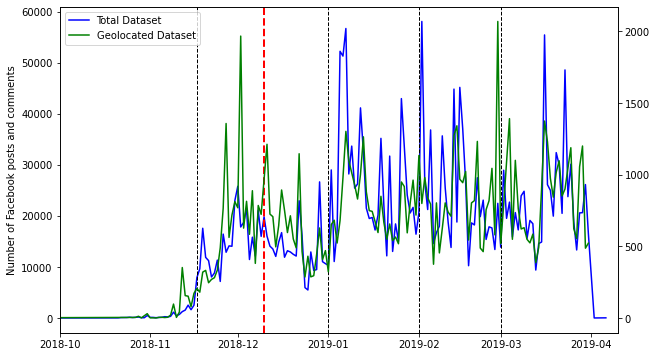

In [22]:
count_sent_by_date = fb_sentences['restrict_date'].value_counts().sort_index()
count_sent_by_date_loc = fb_sentences_loc['restrict_date'].value_counts().sort_index()

# Set up the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(count_sent_by_date.index, count_sent_by_date.values, color='blue', label='Total Dataset')

ax2 = ax1.twinx()
ax2.plot(count_sent_by_date_loc.index, count_sent_by_date_loc.values, color='green', label='Geolocated Dataset')

# Add labels and title
ax1.set_ylabel('Number of Facebook posts and comments')
plt.xticks(rotation=45)

start_date = pd.to_datetime('2018-10-01')
end_date = pd.to_datetime('2019-04-10')
ax1.set_xlim(start_date, end_date)

ax1.axvline(pd.to_datetime('2018-11-17'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2018-12-10'), color='red', linestyle='--', lw=2)
ax1.axvline(pd.to_datetime('2019-01-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-02-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-03-01'), color='black', linestyle='--', lw=1)

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.savefig(path + '/Output/Graphs/PA_loc_dataset/freq_comparison.png')

### 3. Topic analysis of geolocated PA discussions

We do a Wordcloud analysis of that dataset to cluster in geolocated topics discussions about PA, to get intuition about what is at matter in the filtered dataset.

#### a. Preprocessing for Wordcloud

In [23]:
# Word2vec model for that PA filtered dataset
import time
import pandas as pd
import gensim
import gensim
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

window_size = 3
vector_size = 300
n_iterations= 100
n_workers = 1

df = pd.read_csv(path + '/Data/Facebook/fb_sentences_loc_PA.csv')

stop_words = set(stopwords.words('french'))

df['sentence_clean'] = df['sentence_clean'].apply(lambda x: ' '.join([word for word in word_tokenize(str(x)) if word.lower() not in stop_words]))
df['sentence_clean'] = df['sentence_clean'].apply(lambda x: [word for word in str(x).split() if len(word) >= 2])
df['sentence_clean'] = df['sentence_clean'].apply(lambda x: ' '.join(x))
df.dropna(subset=['sentence_clean'], inplace=True)
print(len(df))

corpus = list(df['sentence_clean'])
corpus = [str(sentence).split() for sentence in corpus]

t0 = time.time()
print('Training word embeddings...')
model = gensim.models.Word2Vec(
    sentences = corpus,
    vector_size=vector_size,
    window=window_size,
    min_count=5,
    workers=n_workers,
    epochs = n_iterations,
    seed = 123
)

model.save(path + "/Data/Facebook/model_loc_PA_word.model")
df.to_csv(path + "/Data/Facebook/fb_sentences_loc_PA.csv")

print('Training word embeddings took:')
print(time.time() - t0)

[nltk_data] Downloading package punkt to /Users/clem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/clem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


24386
Training word embeddings...
Training word embeddings took:
54.667344093322754


In [24]:
from tqdm import tqdm
import pickle as pk
import pandas as pd
import numpy as np
from sklearn import preprocessing
from gensim.models import Word2Vec

fb_model = Word2Vec.load(path + "/Data/Facebook/model_loc_PA_word.model")

df = pd.read_csv(path + "/Data/Facebook/fb_sentences_loc_PA.csv")

df['tokens'] = df['sentence_clean'].apply(lambda x: str(x).split())
df.dropna(subset=['tokens'], inplace=True)

word_count_dict = {}
for word, index in fb_model.wv.key_to_index.items():
    word_count_dict[word] = fb_model.wv.get_vecattr(word, "count")

print('Word frequencies computed.')

sif_dict = {}
for word, count in word_count_dict.items():
    sif_dict[word] = 0.001 / (0.001 + count)

print('SIF dictionary built.')

sif_vec_dict = {}

# We put emphasis on sentences targeted on the PA
important_words = ['prime', 'activite', 'activit', '100e', '90e', 'beneficiaire', 'caf', 'revalorisation']  # List of important words

importance_factor = 10  # Importance factor for important words

def get_vector(tokens):
    sif_vec = np.zeros(fb_model.vector_size)  # Initialize the vector as zeros
    count = 0  # Count the number of valid tokens
    
    for one_token in tokens:
        if one_token in fb_model.wv:
            if one_token in important_words:
                sif_vec += sif_dict[one_token] * fb_model.wv[one_token] * importance_factor
            else:
                sif_vec += sif_dict[one_token] * fb_model.wv[one_token]
            count += 1
    
    if count > 0:
        sif_vec /= count
    
    sif_vec = preprocessing.normalize(sif_vec.reshape(1, -1), norm="l2")
    
    return sif_vec

list_of_tokens = list(df['tokens'])

for k, tokens in tqdm(enumerate(list_of_tokens)):
    sif_vec = get_vector(tokens)
    if not np.isnan(sif_vec).any() and not np.isinf(sif_vec).any():
        sif_vec_dict[k] = sif_vec
    else:
        print(f"Ignored document {k} due to NaN or infinity values.")

print("Document embeddings computed.")

with open(path + "/Data/Facebook/comments_sif_dict_loc_PA_emph.pickle", 'wb') as outfile:
    pk.dump(sif_vec_dict, outfile)

Word frequencies computed.
SIF dictionary built.


24386it [00:08, 2793.14it/s]


Document embeddings computed.


In [25]:
len(sif_vec_dict)

24386

In [26]:
# Topic = cluster of embedded sentences. K-means clustering of the PA dataset
import random
import numpy as np
import pandas as pd
import pickle as pk
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

sample_size =  24386 # Size of the sample to train Kmeans
#sample_size = 100000 # Size of the sample to train Kmeans

with open(path + "/Data/Facebook/comments_sif_dict_loc_PA_emph.pickle", 'rb') as pickle_file:
    sif_vec_dict = pk.load(pickle_file)

print("SIF dictionary loaded.")

fb_model = Word2Vec.load(path + "/Data/Facebook/model_loc_PA_word.model")

print('Word embeddings loaded.')

myseed = 1234
random.seed(myseed)

keys = random.sample(list(sif_vec_dict.keys()), sample_size)
sample = {k : sif_vec_dict[k][0] for k in keys}

A = pd.DataFrame.from_dict(sample, orient = 'index')

print("Sample drawn.")

kmeans_models = []

K = [5,10,15]
for num_clusters in K:
    print('Clustering started for %s clusters.' %num_clusters)
    kmeans = KMeans(n_clusters=num_clusters,random_state=myseed,verbose=1).fit(A)
    kmeans_models.append(kmeans)
    print('Clustering done for %s clusters.' %num_clusters)

with open(path + '/Data/Facebook/kmeans_models_loc_PA.pickle', 'wb') as outfile:
    pk.dump(kmeans_models, outfile)

def describe_topics(num_clusters, kmeans_models = kmeans_models):

    for model in kmeans_models:
        if len(model.cluster_centers_) == num_clusters:
            kmeans = model

    doc_clusters = kmeans.labels_.astype(np.float64)
    cluster_centers = kmeans.cluster_centers_.astype(np.float64)

    dict_topics = {}

    for i in range(num_clusters):
        top_closest_words = fb_model.wv.most_similar(positive=[cluster_centers[i]], topn=10)
        top_closest_words = [word[0] for word in top_closest_words]
        s = ', '
        top_closest_words = s.join(top_closest_words)
        dict_topics[str(i)] = top_closest_words

    table_of_topics = pd.DataFrame.from_dict(dict_topics, orient='index')
    table_of_topics.to_csv(path + '/Output/Tables/table_of_topics_loc_PA_%s.tsv' %num_clusters, sep = '\t', index = True)

describe_topics(num_clusters = 5)
describe_topics(num_clusters = 10)

SIF dictionary loaded.
Word embeddings loaded.
Sample drawn.
Clustering started for 5 clusters.
Initialization complete
Iteration 0, inertia 39806.55081747028
Iteration 1, inertia 21968.062336572264
Iteration 2, inertia 21802.187485886738
Iteration 3, inertia 21752.940172954688
Iteration 4, inertia 21719.960995876652
Iteration 5, inertia 21693.245486069718
Iteration 6, inertia 21665.1201187226
Iteration 7, inertia 21644.025710848884
Iteration 8, inertia 21623.822110281333
Iteration 9, inertia 21611.61248320764
Iteration 10, inertia 21604.157258985375
Iteration 11, inertia 21597.99884737697
Iteration 12, inertia 21594.24623602236
Iteration 13, inertia 21591.01213392913
Iteration 14, inertia 21587.290174382666
Iteration 15, inertia 21581.252411605576
Iteration 16, inertia 21577.99433426936
Iteration 17, inertia 21576.151301869868
Iteration 18, inertia 21575.104214029394
Iteration 19, inertia 21574.408172262643
Iteration 20, inertia 21573.992373707842
Iteration 21, inertia 21573.656706769

#### b. Wordcloud analysis

In [27]:
# from PIL import Image,ImageDraw,ImageFont
import numpy as np
import pandas as pd
import string
import pickle as pk
from tqdm import tqdm
import gensim.downloader as api
from gensim.models import Word2Vec, TfidfModel
from gensim.corpora import Dictionary
from wordcloud import WordCloud

num_clusters = 10

with open(path + "/Data/Facebook/comments_sif_dict_loc_PA_emph.pickle", 'rb') as pickle_file:
  sif_vec_dict = pk.load(pickle_file)

print("SIF dictionary loaded.")

with open(path + "/Data/Facebook/kmeans_models_loc_PA.pickle", 'rb') as pickle_file:
  kmeans_models = pk.load(pickle_file)

print('Kmeans models loaded.')

fb_model = Word2Vec.load(path + "/Data/Facebook/model_loc_PA_word.model")

print('Word embeddings loaded.')

df = pd.read_csv(path + "/Data/Facebook/fb_sentences_loc_PA.csv")

for model in kmeans_models:
    if len(model.cluster_centers_) == num_clusters:
        kmeans = model

doc_clusters = kmeans.labels_.astype(np.float64)
cluster_centers = kmeans.cluster_centers_.astype(np.float64)

print('Predicting topics out of sample...')

assigned_clusters = []

for row in tqdm(range(len(df['message_id']))):
    assigned_cluster = kmeans.predict(sif_vec_dict[row])[0]
    assigned_clusters.append(assigned_cluster)

distances_to_centroid = []

for row in tqdm(range(len(df['message_id']))):
    distance_to_centroids = kmeans.transform(sif_vec_dict[row])**2
    distance_to_centroid = distance_to_centroids[0][assigned_clusters[row]]
    distances_to_centroid.append(distance_to_centroid)

df['cluster'] = assigned_clusters
df['distance_to_centroid'] = distances_to_centroid

dict_topics = {}

for i in range(num_clusters):
    top_closest_words = fb_model.wv.most_similar(positive=[cluster_centers[i]], topn=5)
    top_closest_words = [word[0] for word in top_closest_words]
    s = ', '
    top_closest_words = s.join(top_closest_words)
    dict_topics[str(i)] = top_closest_words

for i in range(num_clusters):
    top_closest_words = fb_model.wv.most_similar(positive=[cluster_centers[i]], topn=5)
    top_closest_words = [word[0] for word in top_closest_words]
    s = ', '
    top_closest_words = s.join(top_closest_words)
    dict_topics[str(i)] = top_closest_words
    df.loc[df['cluster'] == i, 'topic_label'] = top_closest_words

corpus = []

for cluster in range(num_clusters):
    messages_in_cluster = ' '.join(list(df.loc[df['cluster'] == cluster, 'sentence_clean'].dropna()))
    messages_in_cluster = str(messages_in_cluster).split()
    corpus.append(messages_in_cluster)

dct = Dictionary(corpus)
corpus = [dct.doc2bow(messages) for messages in corpus]
model = TfidfModel(corpus)


SIF dictionary loaded.
Kmeans models loaded.
Word embeddings loaded.
Predicting topics out of sample...


100%|██████████| 24386/24386 [00:11<00:00, 2142.88it/s]


In [28]:
for cluster in range(num_clusters):
    tf_idf_dtm = model[corpus[cluster]]
    top_words = sorted(tf_idf_dtm, key=lambda x: x[1], reverse=True)[0:9]
    top_words = ' '.join([dct[i] for i,j in top_words])
    df.loc[df['cluster'] == cluster, 'topic_label_tf_idf'] = top_words
    print(top_words)

# Manually label topics
df['topic_manual_label'] = ''
df['topic_manual_label'][df['cluster'] == 0] = '0'
df['topic_manual_label'][df['cluster'] == 1] = '1'
df['topic_manual_label'][df['cluster'] == 2] = '2'
df['topic_manual_label'][df['cluster'] == 3] = '3'
df['topic_manual_label'][df['cluster'] == 4] = '4'
df['topic_manual_label'][df['cluster'] == 5] = '5'
df['topic_manual_label'][df['cluster'] == 6] = '6'
df['topic_manual_label'][df['cluster'] == 7] = '7'
df['topic_manual_label'][df['cluster'] == 8] = '8'
df['topic_manual_label'][df['cluster'] == 9] = '9'
#df['topic_manual_label'][df['cluster'] == 10] = '10'
#df['topic_manual_label'][df['cluster'] == 11] = '11'
#df['topic_manual_label'][df['cluster'] == 12] = '12'
#df['topic_manual_label'][df['cluster'] == 13] = '13'
#df['topic_manual_label'][df['cluster'] == 14] = '14'
#df['topic_manual_label'][df['cluster'] == 15] = '15'
#df['topic_manual_label'][df['cluster'] == 16] = '16'
#df['topic_manual_label'][df['cluster'] == 17] = '17'
#df['topic_manual_label'][df['cluster'] == 18] = '18'
#df['topic_manual_label'][df['cluster'] == 19] = '19'


for cluster in range(num_clusters):
    topic_manual_label = list(set(df["topic_manual_label"][df['cluster'] == cluster]))[0]
    tf_idf_dtm = model[corpus[cluster]]
    top_words = sorted(tf_idf_dtm, key=lambda x: x[1], reverse=True)[0:50]
    top_words = [(dct[i],j) for i,j in top_words]
    top_words = pd.DataFrame.from_records(top_words, columns=['key', 'val'])
    top_words = top_words.set_index('key')
    top_words = top_words['val']
    WordCloud(background_color="white", max_words=50, width=800, height=400).generate_from_frequencies(top_words).to_file(path + '/Output/Topics/wordcloud_loc_PA_%s.png' %topic_manual_label)

ecout discrediter pleurer reagir malheureusement esperai chie insulter connard
therese sansone m2 angelina maddalena marie 06 nathalie anthony
lci placarder rdv diffuser telecharger credibilite disponible superbe communiquer
agriculteur loger enterprise caisse bosser rapporte commerce impot acquis
00 indexation diminution jury imposable mensuel caf cotisation cumul
cice additionnel pme immobilier dividende flat contribution annulation tver
determination bisou voeux lachez boulo prompt sincere gabin heros
manipulateur splendeur degage suceur macaron magouilleur assassin joueur leche
mdrr gaze ball banlieue bombe kan flash casque flashball
souverainete constitution independance souverain referendum fonctionnement fondamental profondeur representation


/var/folders/c1/c29fpvws6xn3j81txnc2_k100000gq/T/ipykernel_19192/1457879320.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_manual_label'][df['cluster'] == 0] = '0'
/var/folders/c1/c29fpvws6xn3j81txnc2_k100000gq/T/ipykernel_19192/1457879320.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_manual_label'][df['cluster'] == 1] = '1'
/var/folders/c1/c29fpvws6xn3j81txnc2_k100000gq/T/ipykernel_19192/1457879320.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [29]:
import pandas as pd
from wordcloud import WordCloud

# Create a dictionary to store the unique top words across clusters
unique_top_words = {}

for cluster in range(num_clusters):
    tf_idf_dtm = model[corpus[cluster]]
    top_words = sorted(tf_idf_dtm, key=lambda x: x[1], reverse=True)[:50]
    
    for i, j in top_words:
        word = dct[i]
        if word not in unique_top_words:
            unique_top_words[word] = (j, cluster)
        else:
            val, prev_cluster = unique_top_words[word]
            if j > val:
                unique_top_words[word] = (j, cluster)
            elif j == val and cluster < prev_cluster:
                unique_top_words[word] = (j, cluster)

# Update the topic labels in the dataframe
df['topic_label_tf_idf'] = ''
for cluster in range(num_clusters):
    top_words = [word for word, (val, c) in unique_top_words.items() if c == cluster]
    top_words = ' '.join(top_words)
    df.loc[df['cluster'] == cluster, 'topic_label_tf_idf'] = top_words

# Manually label topics
df['topic_manual_label'] = df['cluster'].astype(str)

# Generate word cloud for each cluster
for cluster in range(num_clusters):
    topic_manual_label = str(cluster)
    top_words = [word for word, (val, c) in unique_top_words.items() if c == cluster]
    top_words_val = [val for word, (val, c) in unique_top_words.items() if c == cluster]
    
    # Create a dataframe from the top_words and top_words_val lists
    top_words_df = pd.DataFrame({'key': top_words, 'val': top_words_val})
    top_words_df = top_words_df.sort_values(by='val', ascending=False)[:50]
    print((top_words_df[:20]))
    
    # Generate word cloud and save it to a file
    wordcloud = WordCloud(background_color="white", max_words=50, width=800, height=400)
    wordcloud.generate_from_frequencies(top_words_df.set_index('key')['val'])
    wordcloud.to_file(path + '/Output/Topics/wordcloud_PA_loc_%s.png' % topic_manual_label)

                key       val
0             ecout  0.152177
1       discrediter  0.124578
2           pleurer  0.110341
3            reagir  0.099663
4   malheureusement  0.095680
5           esperai  0.091913
6              chie  0.084104
7          insulter  0.081563
8          mepriser  0.073152
9            pitier  0.072089
10         reveille  0.072089
11         terminer  0.071188
12      europeennes  0.069171
13       cacahouete  0.068935
14       deputation  0.068935
15     nationaliste  0.068935
16            samdi  0.068935
17            voter  0.066240
18          craquer  0.064244
19        mecontent  0.064244
            key       val
0       therese  0.435185
1       sansone  0.380098
2            m2  0.198312
3      angelina  0.192803
4     maddalena  0.187295
5         marie  0.184138
6            06  0.154243
7      nathalie  0.154243
8       anthony  0.116182
9      adelaide  0.115682
10         orza  0.115682
11  thinkerview  0.111661
12        muros  0.110173
13    

### 3. Frequency and visibility of PA discussions

#### a. Frequency of Geolocated PA comments

In [30]:
fb_sentences_loc = pd.read_csv(path + '/Data/Facebook/fb_sentences_loc.csv')
fb_sentences_loc_PA = pd.read_csv(path + '/Data/Facebook/fb_sentences_loc_PA.csv')

In [31]:
fb_sentences_loc_PA['date'] = pd.to_datetime(fb_sentences_loc_PA['date'])
fb_sentences_loc_PA['restrict_date'] = fb_sentences_loc_PA['date'].dt.date
fb_sentences_loc_PA['restrict_date'] = pd.to_datetime(fb_sentences_loc_PA['restrict_date'])

Frequency of sentences (comments+posts) posted :

Geolocated dataset (not related to PA, to look if it is representative of the whole not geolocated dataset)

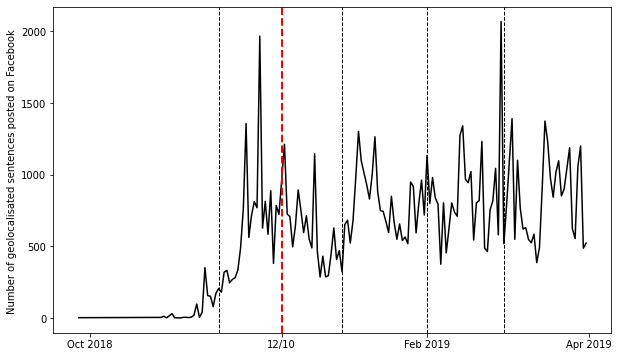

In [33]:
fb_sentences_loc['date'] = pd.to_datetime(fb_sentences_loc['date'])
fb_sentences_loc['restrict_date'] = fb_sentences_loc['date'].dt.date
fb_sentences_loc['restrict_date'] = pd.to_datetime(fb_sentences_loc['restrict_date'])

count_sent_by_date = fb_sentences_loc['restrict_date'].value_counts().sort_index()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(count_sent_by_date.index, count_sent_by_date.values, color ='black')
ax1.set_ylabel('Number of geolocalisated sentences posted on Facebook ', color='black')

xticks = ['2018-10-01', '2018-12-10', '2019-02-01', '2019-04-01']
ax1.set_xticks(xticks)

xticklabels = ["Oct 2018", "12/10", "Feb 2019", "Apr 2019"]
ax1.set_xticklabels(xticklabels)

ax1.axvline(pd.to_datetime('2018-11-17'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2018-12-10'), color='red', linestyle='--', lw=2)
ax1.axvline(pd.to_datetime('2019-01-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-02-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-03-01'), color='black', linestyle='--', lw=1)

plt.savefig(path + '/Output/Graphs/PA_loc_dataset/loc_FBsentences.png')

Geolocated PA dataset :

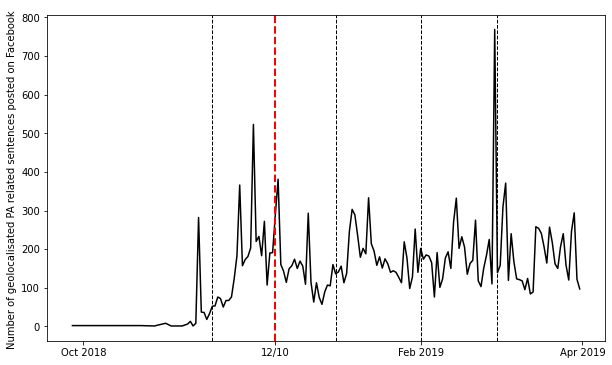

In [34]:
count_sent_by_date = fb_sentences_loc_PA['restrict_date'].value_counts().sort_index()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(count_sent_by_date.index, count_sent_by_date.values, color ='black')
ax1.set_ylabel('Number of geolocalisated PA related sentences posted on Facebook ', color='black')

xticks = ['2018-10-01', '2018-12-10', '2019-02-01', '2019-04-01']
ax1.set_xticks(xticks)

xticklabels = ["Oct 2018", "12/10", "Feb 2019", "Apr 2019"]
ax1.set_xticklabels(xticklabels)

ax1.axvline(pd.to_datetime('2018-11-17'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2018-12-10'), color='red', linestyle='--', lw=2)
ax1.axvline(pd.to_datetime('2019-01-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-02-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-03-01'), color='black', linestyle='--', lw=1)

plt.savefig(path + '/Output/Graphs/PA_loc_dataset/PA_loc_FBsentences.png')

Most used words :

In [35]:
fb_sentences_loc_PA_concat = ' '.join((fb_sentences_loc_PA['sentence_clean'].astype(str)).tolist())
fb_sentences_loc_PA_concat = fb_sentences_loc_PA_concat.split()

from nltk.probability import FreqDist
word_freq = FreqDist(fb_sentences_loc_PA_concat)
print(word_freq.most_common(50))

[('etre', 13491), ('faire', 3518), ('pouvoir', 2218), ('aller', 2186), ('jaune', 1646), ('gilet', 1598), ('falloir', 1557), ('macron', 1280), ('voir', 1146), ('payer', 1096), ('meme', 1092), ('france', 1044), ('devoir', 1019), ('gouvernement', 985), ('monsieur', 950), ('vouloir', 891), ('peuple', 878), ('francais', 827), ('euro', 788), ('retraite', 782), ('donner', 748), ('mois', 727), ('taxe', 716), ('argent', 708), ('grand', 679), ('prendre', 670), ('salaire', 667), ('vie', 608), ('savoir', 604), ('mouvement', 601), ('mettre', 579), ('petit', 567), ('travail', 547), ('monde', 544), ('gj', 537), ('courage', 518), ('politique', 517), ('casseur', 515), ('tres', 507), ('pays', 506), ('bravo', 504), ('peur', 495), ('super', 493), ('annee', 489), ('heure', 485), ('etat', 478), ('oui', 477), ('passer', 476), ('mdr', 469), ('droit', 443)]


#### b. Visibility of PA discussions compared to other discussions

We measure visibility through :
- Post visibility : the number of comments to that post
- Comments visibility : the "ranking" of the comments (ordered by Facebook, so giving less or more visibility of some comments compared to other under the post)

1. Mean visibility of PA posts compared to the total dataset:

In [36]:
mean_visibility_pa = fb_sentences_loc[fb_sentences_loc['PA_related'] == 1].groupby('message_id')['total_sentences'].mean()
mean_visibility_total = fb_sentences_loc.groupby('message_id')['total_sentences'].mean()

overall_mean_visibility_pa = mean_visibility_pa.mean()
overall_mean_visibility_total = mean_visibility_total.mean()

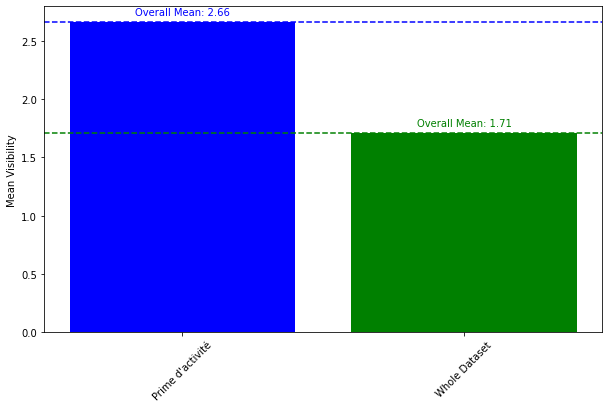

In [37]:
import matplotlib.pyplot as plt

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the mean visibility for sentences related to "prime d'activité"
ax.bar('Prime d\'activité', mean_visibility_pa.mean(), color='blue')

# Plot the mean visibility for the whole dataset
ax.bar('Whole Dataset', mean_visibility_total.mean(), color='green')

# Add labels and title
ax.set_ylabel('Mean Visibility')
plt.xticks(rotation=45)

# Add horizontal line for overall mean visibility
ax.axhline(y=overall_mean_visibility_pa, color='blue', linestyle='--')
ax.axhline(y=overall_mean_visibility_total, color='green', linestyle='--')

# Add text annotation for overall mean visibility
ax.annotate(f'Overall Mean: {overall_mean_visibility_pa:.2f}',
             xy=('Prime d\'activité', overall_mean_visibility_pa),
             xytext=(0, 5),
             textcoords='offset points',
             ha='center',
             va='bottom',
             color='blue')

ax.annotate(f'Overall Mean: {overall_mean_visibility_total:.2f}',
             xy=('Whole Dataset', overall_mean_visibility_total),
             xytext=(0, 5),
             textcoords='offset points',
             ha='center',
             va='bottom',
             color='green')

# Display the plot
plt.savefig(path + '/Output/Graphs/PA_loc_dataset/mean_visibility_pa_loc.png')

2. Visibility over time of PA posts compared to the total dataset:

In [38]:
post_data = fb_sentences_loc[fb_sentences_loc['type'] == 'post']

# Group by restrict_date and calculate mean visibility for PA-related and total sentences
mean_visibility_pa = post_data[post_data['PA_related'] == 1].groupby(pd.Grouper(key='restrict_date', freq='W'))['total_sentences'].mean()
mean_visibility_total = post_data.groupby(pd.Grouper(key='restrict_date', freq='W'))['total_sentences'].mean()

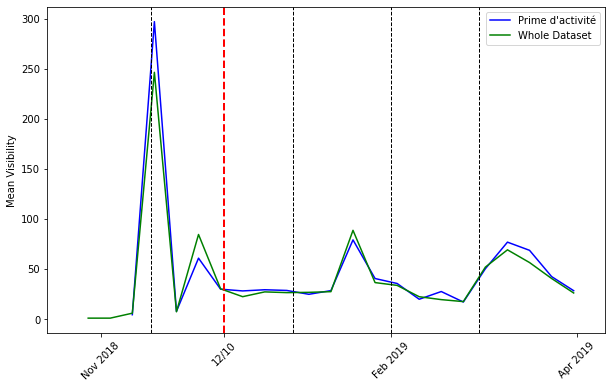

In [44]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the mean visibility for sentences related to "prime d'activité"
ax.plot(mean_visibility_pa.index, mean_visibility_pa.values, color='blue', label='Prime d\'activité')

# Plot the mean visibility for the whole dataset
ax.plot(mean_visibility_total.index, mean_visibility_total.values, color='green', label='Whole Dataset')

# Add labels and title
ax.set_ylabel('Mean Visibility')
plt.xticks(rotation=45)

start_date = pd.to_datetime('2018-10-15')
end_date = pd.to_datetime('2019-04-10')
ax.set_xlim(start_date, end_date)

xticks = ['2018-11-01', '2018-12-10', '2019-02-01', '2019-04-01']
ax.set_xticks(xticks)

xticklabels = ["Nov 2018", "12/10", "Feb 2019", "Apr 2019"]
ax.set_xticklabels(xticklabels)

ax.axvline(pd.to_datetime('2018-11-17'), color='black', linestyle='--', lw=1)
ax.axvline(pd.to_datetime('2018-12-10'), color='red', linestyle='--', lw=2)
ax.axvline(pd.to_datetime('2019-01-01'), color='black', linestyle='--', lw=1)
ax.axvline(pd.to_datetime('2019-02-01'), color='black', linestyle='--', lw=1)
ax.axvline(pd.to_datetime('2019-03-01'), color='black', linestyle='--', lw=1)
# Add legend
ax.legend()

# Display the plot
plt.savefig(path + '/Output/Graphs/PA_loc_dataset/mean_visibility_pa_loc_time.png')

3. Mean visibility "ranking" of PA comments compared to the total dataset:

In [45]:
fb_sentences_loc['rank_prop'] = 1 - fb_sentences_loc['sentence_id']/fb_sentences_loc['total_sentences']

mean_rank_pa = fb_sentences_loc[fb_sentences_loc['PA_related'] == 1].groupby('message_id')['rank_prop'].mean()
mean_rank_total = fb_sentences_loc.groupby('message_id')['rank_prop'].mean()

overall_mean_rank_pa = mean_rank_pa.mean()
overall_mean_rank_total = mean_rank_total.mean()

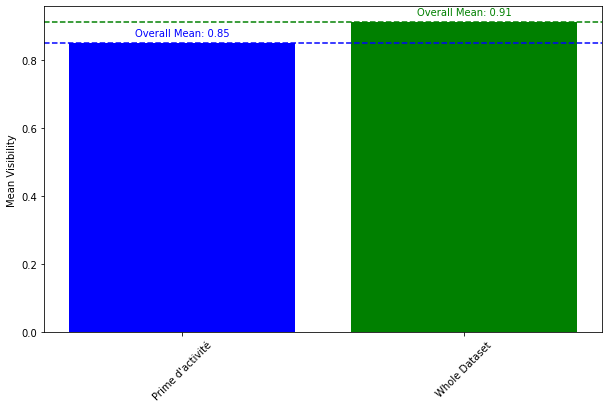

In [46]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the mean visibility for sentences related to "prime d'activité"
ax.bar('Prime d\'activité', mean_rank_pa.mean(), color='blue')

# Plot the mean visibility for the whole dataset
ax.bar('Whole Dataset', mean_rank_total.mean(), color='green')

# Add labels and title
ax.set_ylabel('Mean Visibility')
plt.xticks(rotation=45)

# Add horizontal line for overall mean visibility
ax.axhline(y=overall_mean_rank_pa, color='blue', linestyle='--')
ax.axhline(y=overall_mean_rank_total, color='green', linestyle='--')

# Add text annotation for overall mean visibility
ax.annotate(f'Overall Mean: {overall_mean_rank_pa:.2f}',
             xy=('Prime d\'activité', overall_mean_rank_pa),
             xytext=(0, 5),
             textcoords='offset points',
             ha='center',
             va='bottom',
             color='blue')

ax.annotate(f'Overall Mean: {overall_mean_rank_total:.2f}',
             xy=('Whole Dataset', overall_mean_rank_total),
             xytext=(0, 5),
             textcoords='offset points',
             ha='center',
             va='bottom',
             color='green')


# Display the plot
plt.savefig(path + '/Output/Graphs/PA_loc_dataset/mean_rank_pa_loc.png')

4. Visibility over time of "ranking" of PA comments compared to the total dataset:

In [47]:
post_data = fb_sentences_loc[fb_sentences_loc['type'] == 'post']
# Group by restrict_date and calculate mean visibility for PA-related and total sentences
mean_rank_pa = post_data[post_data['PA_related'] == 1].groupby(pd.Grouper(key='restrict_date', freq='W'))['rank_prop'].mean()
mean_rank_total = post_data.groupby(pd.Grouper(key='restrict_date', freq='W'))['rank_prop'].mean()

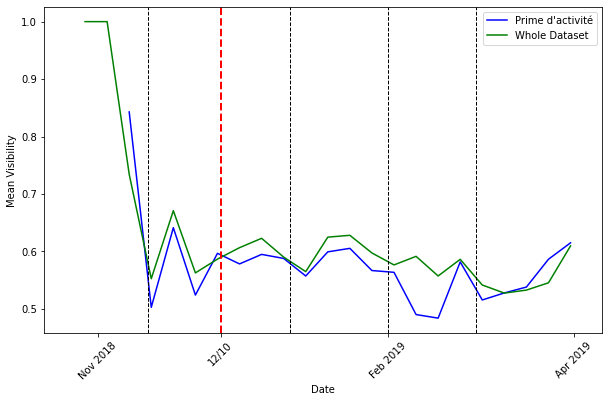

In [49]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the mean visibility for sentences related to "prime d'activité"
ax.plot(mean_rank_pa.index, mean_rank_pa.values, color='blue', label='Prime d\'activité')

# Plot the mean visibility for the whole dataset
ax.plot(mean_rank_total.index, mean_rank_total.values, color='green', label='Whole Dataset')

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Mean Visibility')
plt.xticks(rotation=45)

start_date = pd.to_datetime('2018-10-15')
end_date = pd.to_datetime('2019-04-10')
ax.set_xlim(start_date, end_date)

xticks = ['2018-11-01', '2018-12-10', '2019-02-01', '2019-04-01']
ax.set_xticks(xticks)

xticklabels = ["Nov 2018", "12/10", "Feb 2019", "Apr 2019"]
ax.set_xticklabels(xticklabels)

ax.axvline(pd.to_datetime('2018-11-17'), color='black', linestyle='--', lw=1)
ax.axvline(pd.to_datetime('2018-12-10'), color='red', linestyle='--', lw=2)
ax.axvline(pd.to_datetime('2019-01-01'), color='black', linestyle='--', lw=1)
ax.axvline(pd.to_datetime('2019-02-01'), color='black', linestyle='--', lw=1)
ax.axvline(pd.to_datetime('2019-03-01'), color='black', linestyle='--', lw=1)

# Add legend
ax.legend()

# Display the plot
plt.savefig(path + '/Output/Graphs/PA_loc_dataset/mean_rank_pa_loc_time.png')

### 4. Sentiment analysis of geolocated PA discussions

#### a. Sentiment analysis

In [50]:
from tqdm import tqdm
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

/Users/clem/Documents/Memoire/venvGJ/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [51]:
print('Measuring sentiment in the Facebook corpus...')
senti_list_textblob = []

for i in tqdm(list(fb_sentences_loc_PA["sentence_clean"])):
    vs = tb(i).sentiment[0]
    senti_list_textblob.append(vs)
        
fb_sentences_loc_PA["sentiment_textblob"]=senti_list_textblob

senti_list_vader = []

for i in tqdm(list(fb_sentences_loc_PA["sentence_clean"])):
    vs = vader.polarity_scores(i)['compound']
    senti_list_vader.append(vs)
        
fb_sentences_loc_PA["sentiment_vader"]=senti_list_vader

print("Correlation between the two measures: %s" %fb_sentences_loc_PA['sentiment_textblob'].corr(fb_sentences_loc_PA['sentiment_vader']))

Measuring sentiment in the Facebook corpus...


100%|██████████| 24386/24386 [00:06<00:00, 3513.45it/s]

Correlation between the two measures: 0.31758051411349797


Sentiment polarity over time:

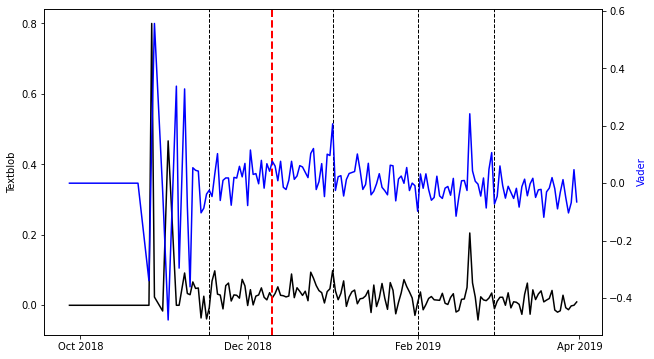

In [52]:
mean_score_vader_by_date = fb_sentences_loc_PA.groupby('restrict_date')['sentiment_vader'].mean()
mean_score_blob_by_date = fb_sentences_loc_PA.groupby('restrict_date')['sentiment_textblob'].mean()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(mean_score_blob_by_date.index, mean_score_blob_by_date.values, color ='black')

ax1.set_ylabel('Textblob', color='black')
xticks = ['2018-10-01', '2018-12-01', '2019-02-01', '2019-04-01']
ax1.set_xticks(xticks)

xticklabels = ["Oct 2018", "Dec 2018", "Feb 2019", "Apr 2019"]
ax1.set_xticklabels(xticklabels)


ax1.axvline(pd.to_datetime('2018-11-17'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2018-12-10'), color='red', linestyle='--', lw=2)
ax1.axvline(pd.to_datetime('2019-01-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-02-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-03-01'), color='black', linestyle='--', lw=1)

ax2 = ax1.twinx()

# Plot the second variable on the right axis
ax2.plot(mean_score_vader_by_date.index, mean_score_vader_by_date.values, color='blue')
ax2.set_ylabel('Vader', color='blue')
ax2.tick_params(axis='y', labelcolor='black')


plt.savefig(path + '/Output/Graphs/PA_loc_dataset/sent_polarity_merged.png')

In [53]:
count_sent_by_date = fb_sentences_loc_PA['restrict_date'].value_counts().sort_index()
count_msg_by_date = fb_sentences_loc_PA.groupby('restrict_date')['message_id'].nunique()

Sentences polarity and sentences frequences over time:

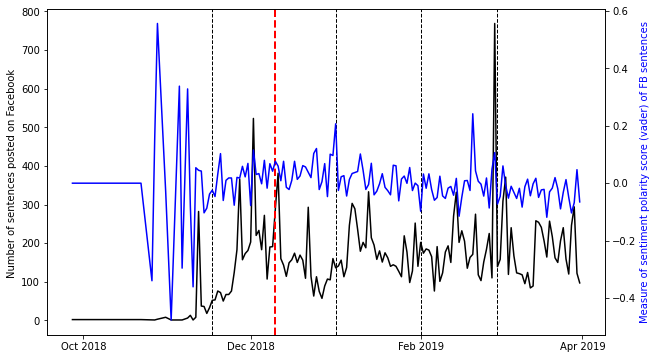

In [54]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(count_sent_by_date.index, count_sent_by_date.values, color ='black')

ax1.set_ylabel('Number of sentences posted on Facebook ', color='black')
xticks = ['2018-10-01', '2018-12-01', '2019-02-01', '2019-04-01']
ax1.set_xticks(xticks)

xticklabels = ["Oct 2018", "Dec 2018", "Feb 2019", "Apr 2019"]
ax1.set_xticklabels(xticklabels)

ax1.axvline(pd.to_datetime('2018-11-17'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2018-12-10'), color='red', linestyle='--', lw=2)
ax1.axvline(pd.to_datetime('2019-01-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-02-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-03-01'), color='black', linestyle='--', lw=1)

ax2 = ax1.twinx()

# Plot the second variable on the right axis
ax2.plot(mean_score_blob_by_date.index, mean_score_vader_by_date.values, color='blue')
ax2.set_ylabel('Measure of sentiment polarity score (vader) of FB sentences', color='blue')
ax2.tick_params(axis='y', labelcolor='black')

plt.savefig(path + '/Output/Graphs/PA_loc_dataset/FBsent_polarity_freq_PA_loc.png')

Aggregated per week:

In [55]:
fb_sentences_loc_PA['restrict_date'] = pd.to_datetime(fb_sentences_loc_PA['restrict_date'])
mean_score_vader_by_week = fb_sentences_loc_PA.groupby(pd.Grouper(key='restrict_date', freq='W'))['sentiment_vader'].mean()
mean_score_blob_by_week = fb_sentences_loc_PA.groupby(pd.Grouper(key='restrict_date', freq='W'))['sentiment_textblob'].mean()

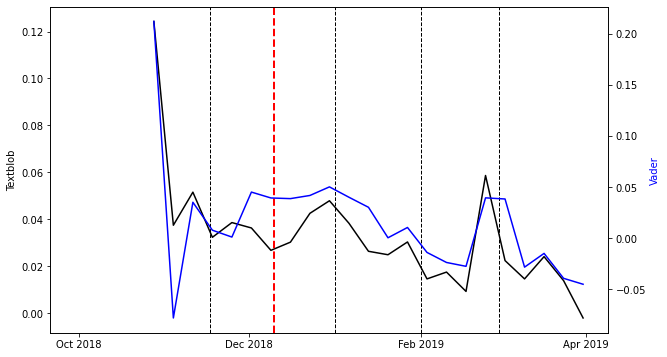

In [56]:
mean_score_vader_by_date = fb_sentences_loc_PA.groupby('restrict_date')['sentiment_vader'].mean()
mean_score_blob_by_date = fb_sentences_loc_PA.groupby('restrict_date')['sentiment_textblob'].mean()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(mean_score_blob_by_week.index, mean_score_blob_by_week.values, color ='black')

ax1.set_ylabel('Textblob', color='black')
xticks = ['2018-10-01', '2018-12-01', '2019-02-01', '2019-04-01']
ax1.set_xticks(xticks)

xticklabels = ["Oct 2018", "Dec 2018", "Feb 2019", "Apr 2019"]
ax1.set_xticklabels(xticklabels)


ax1.axvline(pd.to_datetime('2018-11-17'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2018-12-10'), color='red', linestyle='--', lw=2)
ax1.axvline(pd.to_datetime('2019-01-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-02-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-03-01'), color='black', linestyle='--', lw=1)

ax2 = ax1.twinx()

# Plot the second variable on the right axis
ax2.plot(mean_score_vader_by_week.index, mean_score_vader_by_week.values, color='blue')
ax2.set_ylabel('Vader', color='blue')
ax2.tick_params(axis='y', labelcolor='black')


plt.savefig(path + '/Output/Graphs/PA_loc_dataset/sent_polarity_merged.png')

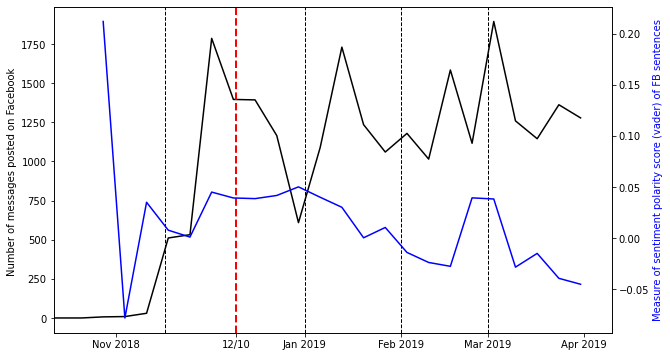

In [59]:
# Aggregating data per week to have less noisy signal : 
count_sent_by_week = fb_sentences_loc_PA.groupby(pd.Grouper(key='restrict_date', freq='W')).size()
count_msg_by_week = fb_sentences_loc_PA.groupby(pd.Grouper(key='restrict_date', freq='W'))['message_id'].nunique()

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(count_sent_by_week.index, count_sent_by_week.values, color ='black')

ax1.set_ylabel('Number of messages posted on Facebook ', color='black')
xticks = ['2018-11-01', '2018-12-10','2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01']
ax1.set_xticks(xticks)

xticklabels = ["Nov 2018", "12/10", "Jan 2019", "Feb 2019", "Mar 2019", "Apr 2019"]
ax1.set_xticklabels(xticklabels)

ax1.axvline(pd.to_datetime('2018-11-17'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2018-12-10'), color='red', linestyle='--', lw=2)
ax1.axvline(pd.to_datetime('2019-01-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-02-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-03-01'), color='black', linestyle='--', lw=1)

ax2 = ax1.twinx()

# Plot the second variable on the right axis
ax2.plot(mean_score_vader_by_week.index, mean_score_vader_by_week.values, color='blue')
ax2.set_ylabel('Measure of sentiment polarity score (vader) of FB sentences', color='blue')
#ax2.tick_params(axis='y', labelcolor='black')

start_date = pd.to_datetime('2018-10-12')
end_date = pd.to_datetime('2019-04-10')
ax1.set_xlim(start_date, end_date)
ax2.set_xlim(start_date, end_date)

plt.savefig(path + '/Output/Graphs/PA_loc_dataset/FBsent_polarity_freq_PA_loc_week.png')

#### b. Sentiment analysis taking visibility into account

Weighting polarity with visibility, according to 2 previous measure + the multiplication of both.

In [60]:
# Weighting by number of answers to the post (post visibility)
grouped_data_mess_visibility = fb_sentences_loc_PA.groupby(pd.Grouper(key='restrict_date', freq='W')).apply(lambda x: np.average(x['sentiment_vader'], weights=x['total_sentences']) if x['total_sentences'].sum() != 0 else np.nan).reset_index(name='weighted_mean_sentiment')

# Weighting by visibility of answers to the post (sentences visibility)
fb_sentences_loc_PA['visibility_rank'] = fb_sentences_loc_PA.groupby('message_id').cumcount()
fb_sentences_loc_PA['visibility_rank'] += 1
grouped_data_sent_visibility = fb_sentences_loc_PA.groupby(pd.Grouper(key='restrict_date', freq='W')).apply(lambda x: np.average(x['sentiment_vader'], weights=x['visibility_rank']) if x['visibility_rank'].sum() != 0 else np.nan).reset_index(name='weighted_mean_sentiment')

# Weighting by both
fb_sentences_loc_PA['sentence_weight'] = fb_sentences_loc_PA['total_sentences'] * fb_sentences_loc_PA['visibility_rank']
grouped_data_both = fb_sentences_loc_PA.groupby(pd.Grouper(key='restrict_date', freq='W')).apply(lambda x: np.average(x['sentiment_vader'], weights=x['sentence_weight']) if x['sentence_weight'].sum() != 0 else np.nan).reset_index(name='weighted_mean_sentiment')


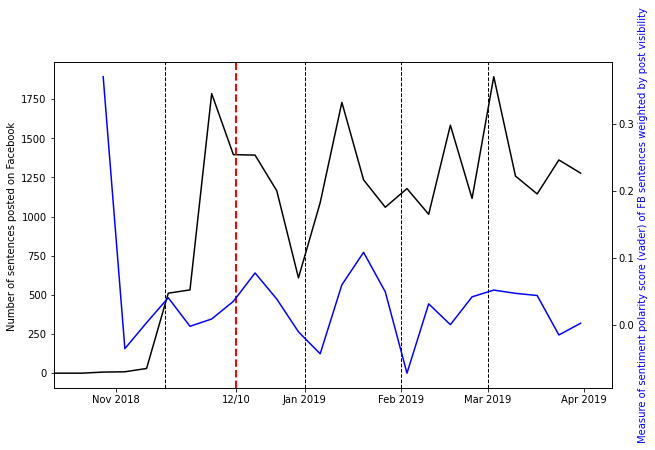

In [61]:
# Plot the weighted mean sentiment polarity for post visibility
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(count_sent_by_week.index, count_sent_by_week.values, color ='black')

ax1.set_ylabel('Number of sentences posted on Facebook ', color='black')
xticks = ['2018-11-01', '2018-12-10','2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01']
ax1.set_xticks(xticks)

xticklabels = ["Nov 2018", "12/10", "Jan 2019", "Feb 2019", "Mar 2019", "Apr 2019"]
ax1.set_xticklabels(xticklabels)

ax1.axvline(pd.to_datetime('2018-11-17'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2018-12-10'), color='red', linestyle='--', lw=2)
ax1.axvline(pd.to_datetime('2019-01-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-02-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-03-01'), color='black', linestyle='--', lw=1)

ax2 = ax1.twinx()

ax2.plot(grouped_data_mess_visibility['restrict_date'], grouped_data_mess_visibility['weighted_mean_sentiment'], color='blue')
# Plot the second variable on the right axis
ax2.set_ylabel('Measure of sentiment polarity score (vader) of FB sentences weighted by post visibility', color='blue')
ax2.tick_params(axis='y', labelcolor='black')

start_date = pd.to_datetime('2018-10-12')
end_date = pd.to_datetime('2019-04-10')
ax1.set_xlim(start_date, end_date)
ax2.set_xlim(start_date, end_date)

plt.savefig(path + '/Output/Graphs/PA_loc_dataset/FBsent_polarity_freq_PA_loc_week_weighted_post.png')

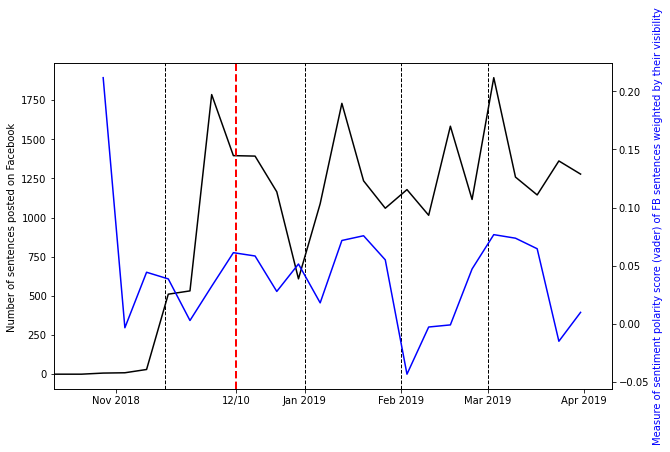

In [62]:
# Plot the weighted mean sentiment polarity for sentence visibility
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(count_sent_by_week.index, count_sent_by_week.values, color ='black')

ax1.set_ylabel('Number of sentences posted on Facebook ', color='black')
xticks = ['2018-11-01', '2018-12-10','2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01']
ax1.set_xticks(xticks)

xticklabels = ["Nov 2018", "12/10", "Jan 2019", "Feb 2019", "Mar 2019", "Apr 2019"]
ax1.set_xticklabels(xticklabels)

ax1.axvline(pd.to_datetime('2018-11-17'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2018-12-10'), color='red', linestyle='--', lw=2)
ax1.axvline(pd.to_datetime('2019-01-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-02-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-03-01'), color='black', linestyle='--', lw=1)

ax2 = ax1.twinx()

ax2.plot(grouped_data_sent_visibility['restrict_date'], grouped_data_sent_visibility['weighted_mean_sentiment'], color='blue')
# Plot the second variable on the right axis
ax2.set_ylabel('Measure of sentiment polarity score (vader) of FB sentences weighted by their visibility', color='blue')
ax2.tick_params(axis='y', labelcolor='black')

start_date = pd.to_datetime('2018-10-12')
end_date = pd.to_datetime('2019-04-10')
ax1.set_xlim(start_date, end_date)
ax2.set_xlim(start_date, end_date)

plt.savefig(path + '/Output/Graphs/PA_loc_dataset/FBsent_polarity_freq_PA_loc_week_weighted_sent.png')

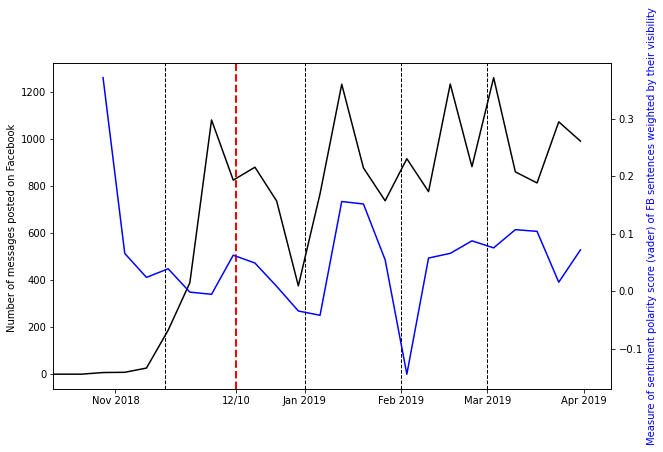

In [63]:
# Plot the weighted mean sentiment polarity for both weight
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(count_msg_by_week.index, count_msg_by_week.values, color ='black')

ax1.set_ylabel('Number of messages posted on Facebook ', color='black')
xticks = ['2018-11-01', '2018-12-10','2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01']
ax1.set_xticks(xticks)

xticklabels = ["Nov 2018", "12/10", "Jan 2019", "Feb 2019", "Mar 2019", "Apr 2019"]
ax1.set_xticklabels(xticklabels)

ax1.axvline(pd.to_datetime('2018-11-17'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2018-12-10'), color='red', linestyle='--', lw=2)
ax1.axvline(pd.to_datetime('2019-01-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-02-01'), color='black', linestyle='--', lw=1)
ax1.axvline(pd.to_datetime('2019-03-01'), color='black', linestyle='--', lw=1)

ax2 = ax1.twinx()

ax2.plot(grouped_data_both['restrict_date'], grouped_data_both['weighted_mean_sentiment'], color='blue')
# Plot the second variable on the right axis
ax2.set_ylabel('Measure of sentiment polarity score (vader) of FB sentences weighted by their visibility', color='blue')
ax2.tick_params(axis='y', labelcolor='black')

start_date = pd.to_datetime('2018-10-12')
end_date = pd.to_datetime('2019-04-10')
ax1.set_xlim(start_date, end_date)
ax2.set_xlim(start_date, end_date)

plt.savefig(path + '/Output/Graphs/PA_loc_dataset/FBsent_polarity_freq_PA_loc_week_weighted_both.png')
